In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA, ARMA, arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

%matplotlib inline

In [2]:
# 设置图片参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小
plt.rcParams['savefig.dpi'] = 300  # 图片像素
# plt.rcParams['figure.dpi'] = 300  # 分辨率

In [3]:
def error_prop(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

## 1 数据预处理

In [4]:
# 加载数据
data_path = "../data/engine_oil.txt"
df = pd.read_csv(data_path, sep='\t', encoding='utf-8')

In [5]:
df = df.rename(columns={'物料编码': 'part_id', '物料描述': 'part_name', 
                        '订货数': 'order_num', '缺件数': 'out_of_stock_num', 
                        '受理数': 'delivery_num', '审核日期': 'date', '审核时间': 'time'})

# 将`part_id`的数据类型设为字符串，方便后面进行重采样 
df['part_id'] = df['part_id'].astype('str')

# 重置索引
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.set_index('date', inplace=True)

In [6]:
# 去除2016年10月份的数据
df = df[3:]

In [7]:
# 重采样
df_day = df.resample('D').sum()

In [8]:
train_day = df_day[:-90]
test_day = df_day[-90:]

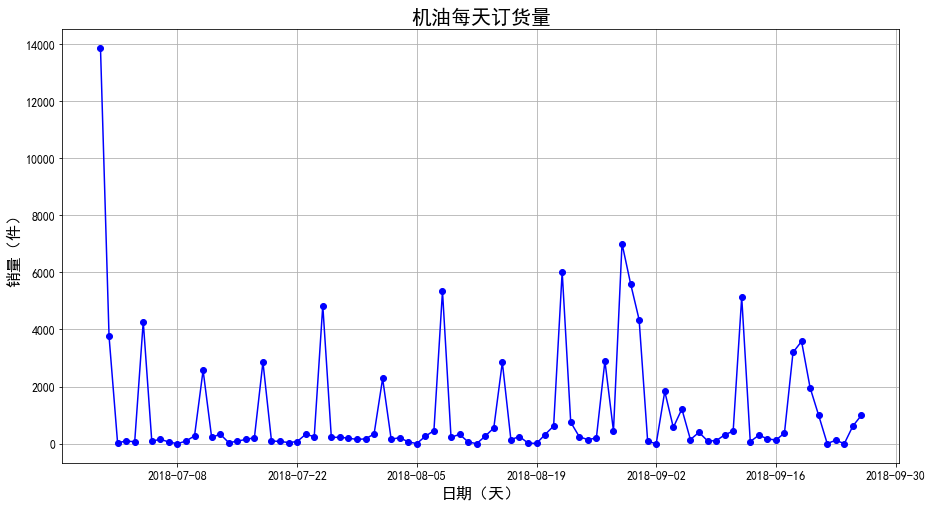

In [40]:
fig, ax = plt.subplots()
ax.plot(test_day.index, test_day.order_num.values, 'bo-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每天订货量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [46]:
df_day['month'] = df_day.index.month

In [62]:
df_day['year'] = df_day.index.year

In [66]:
temp = (df_day['month'] > 7) & (df_day['month'] < 10) & (df_day['year'] == 2017)

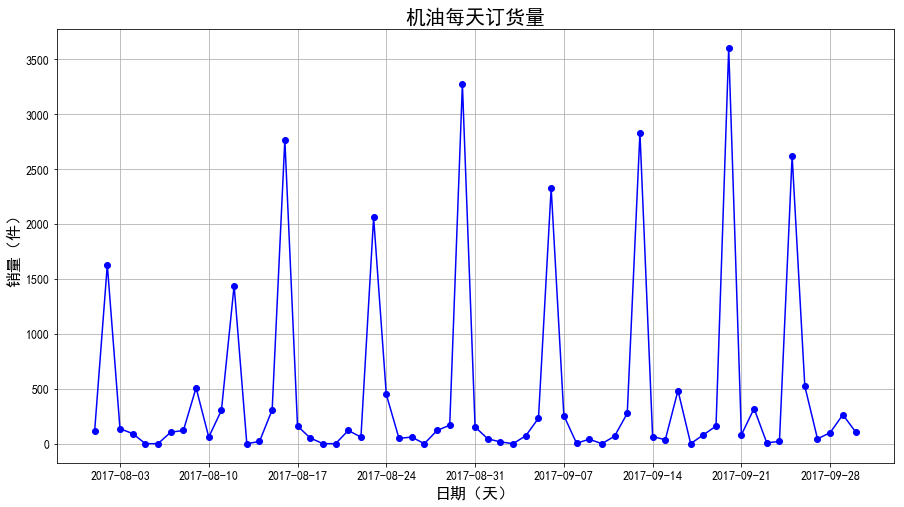

In [67]:
fig, ax = plt.subplots()
ax.plot(df_day[temp].index, df_day[temp].order_num.values, 'bo-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每天订货量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 画出每周每天的时间序列

In [15]:
df_day['weekday'] = df_day.index.weekday

In [18]:
df_day_mon = df_day[df_day.weekday == 0]

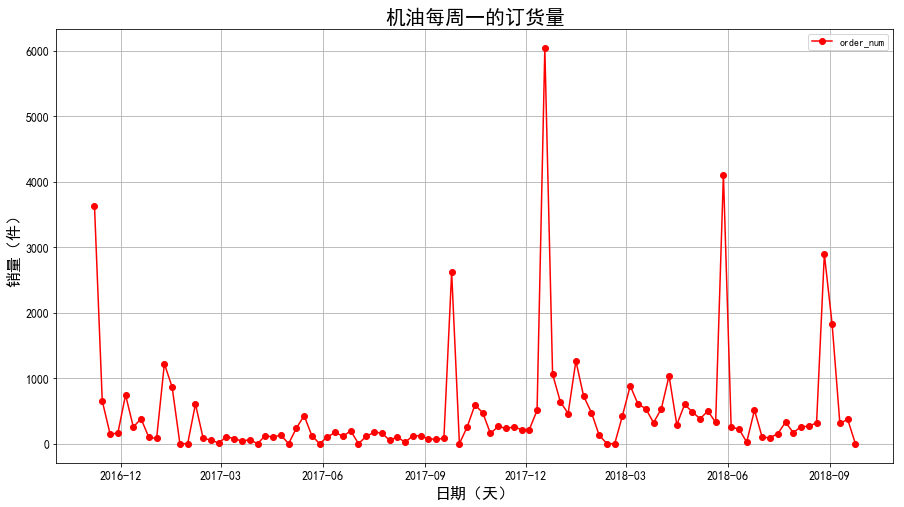

In [33]:
fig, ax = plt.subplots()
ax.plot(df_day_mon.order_num, 'ro-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周一的订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [20]:
df_day_tue = df_day[df_day.weekday == 1]

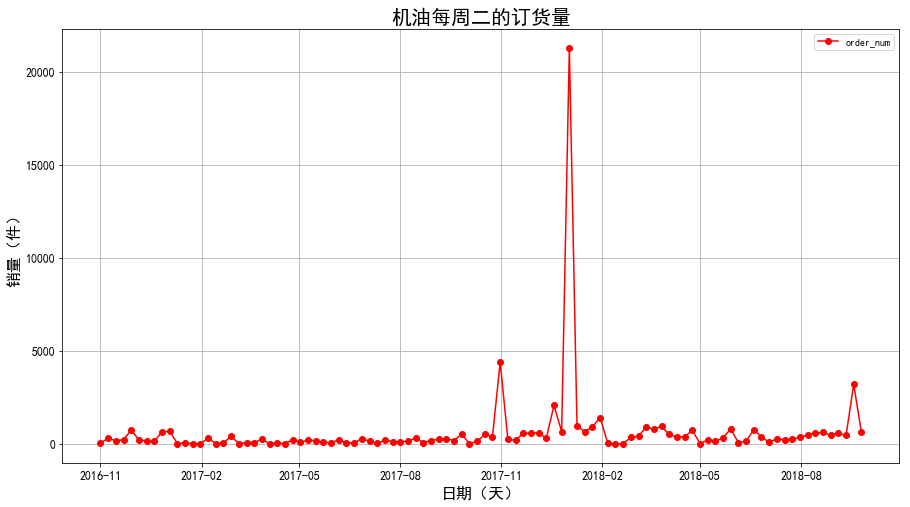

In [34]:
fig, ax = plt.subplots()
ax.plot(df_day_tue.order_num, 'ro-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周二的订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [22]:
df_day_wed = df_day[df_day.weekday == 2]

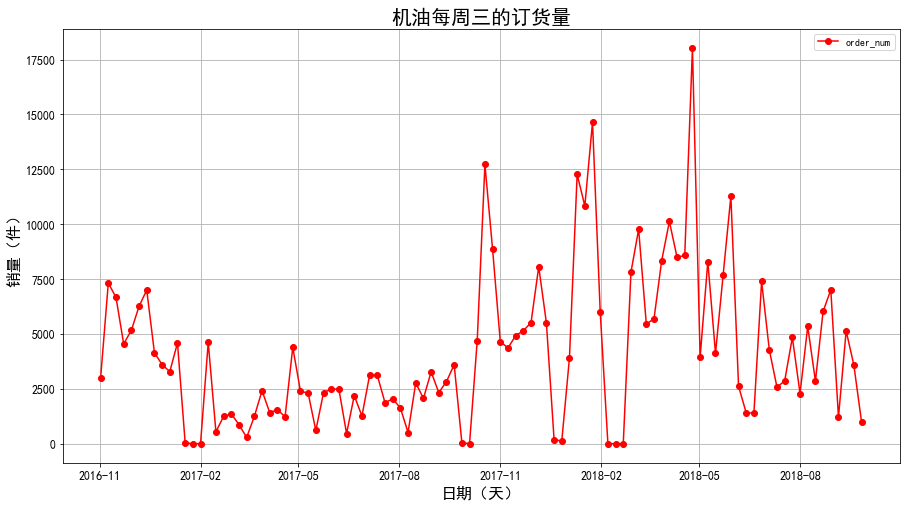

In [35]:
fig, ax = plt.subplots()
ax.plot(df_day_wed.order_num, 'ro-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周三的订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [24]:
df_day_thu = df_day[df_day.weekday == 3]

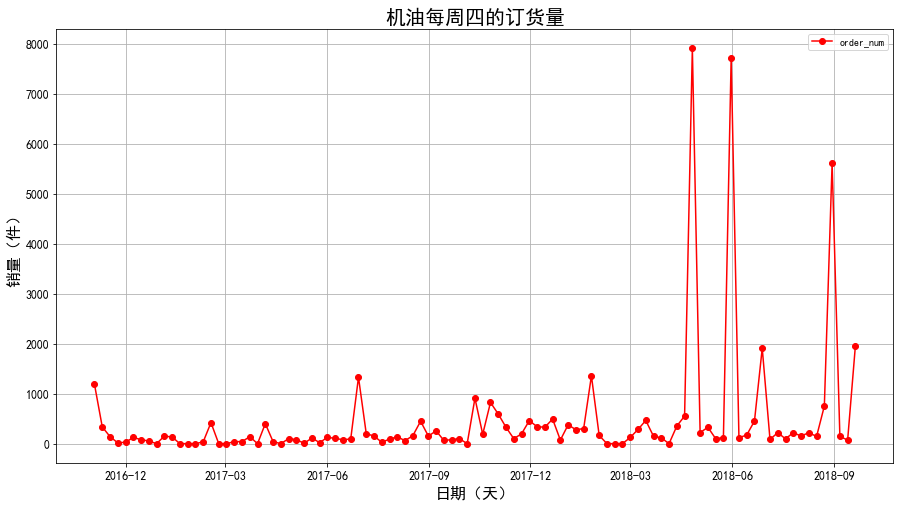

In [36]:
fig, ax = plt.subplots()
ax.plot(df_day_thu.order_num, 'ro-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周四的订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [26]:
df_day_fri = df_day[df_day.weekday == 4]

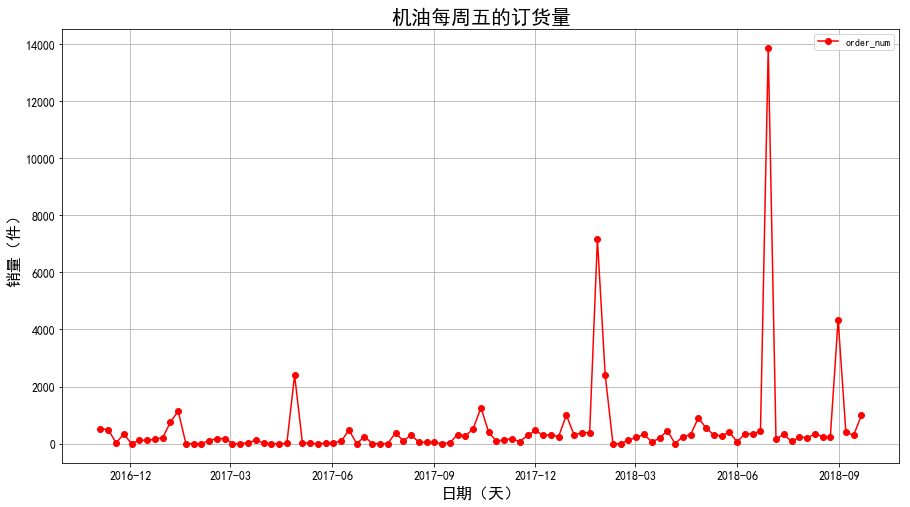

In [37]:
fig, ax = plt.subplots()
ax.plot(df_day_fri.order_num, 'ro-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周五的订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [28]:
df_day_sat = df_day[df_day.weekday == 5]

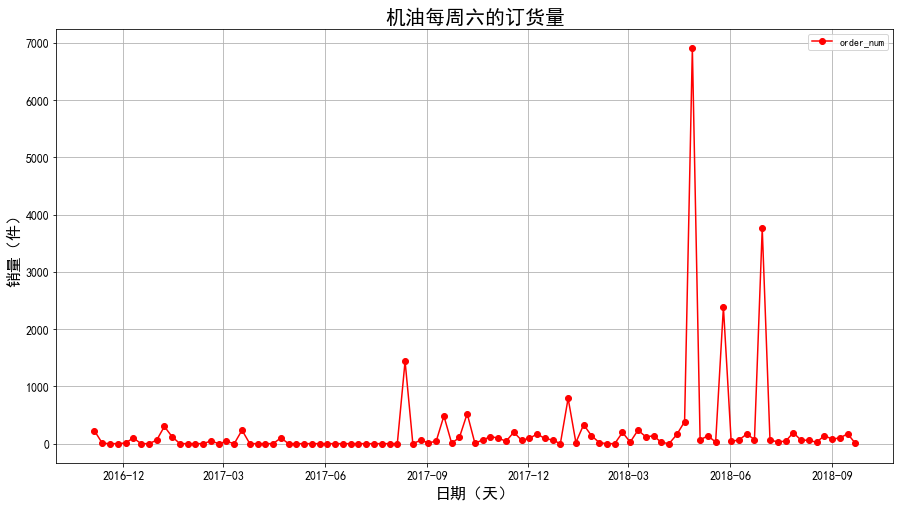

In [38]:
fig, ax = plt.subplots()
ax.plot(df_day_sat.order_num, 'ro-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周六的订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [30]:
df_day_sun = df_day[df_day.weekday == 6]

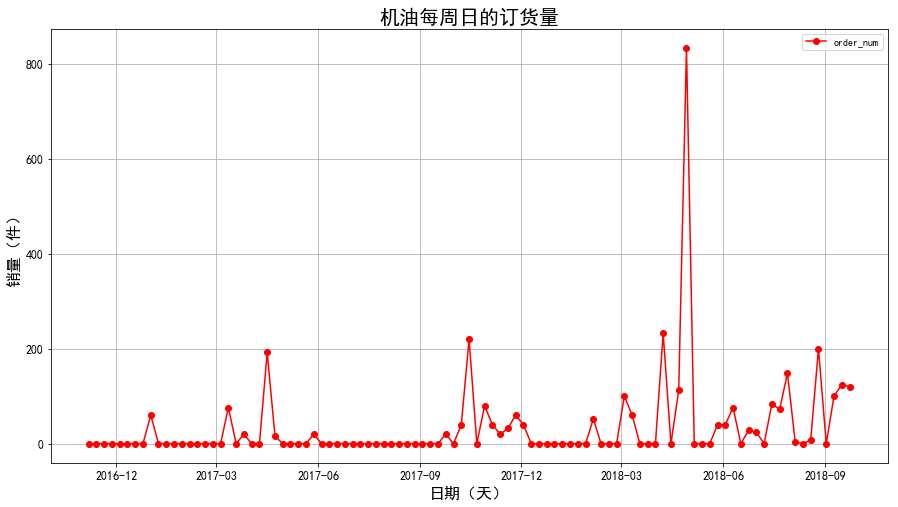

In [39]:
fig, ax = plt.subplots()
ax.plot(df_day_sun.order_num, 'ro-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('机油每周日的订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 2 时间序列检验

### 2.1 自相关图和偏自相关图

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


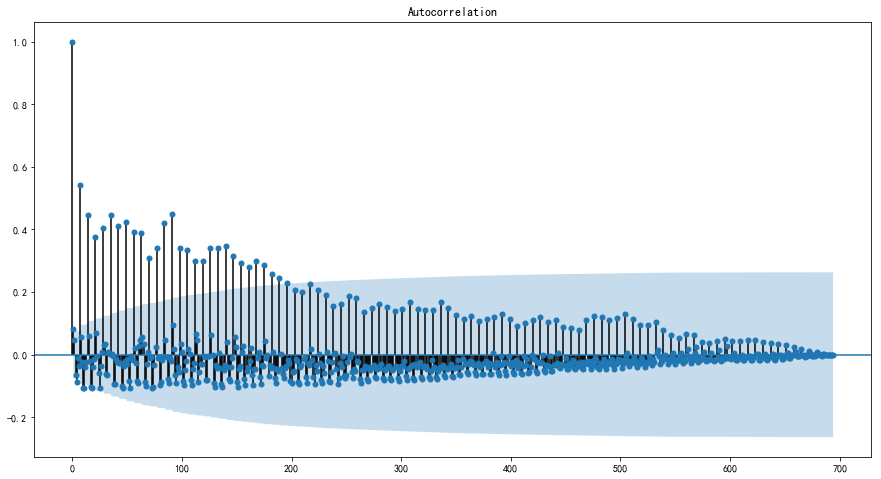

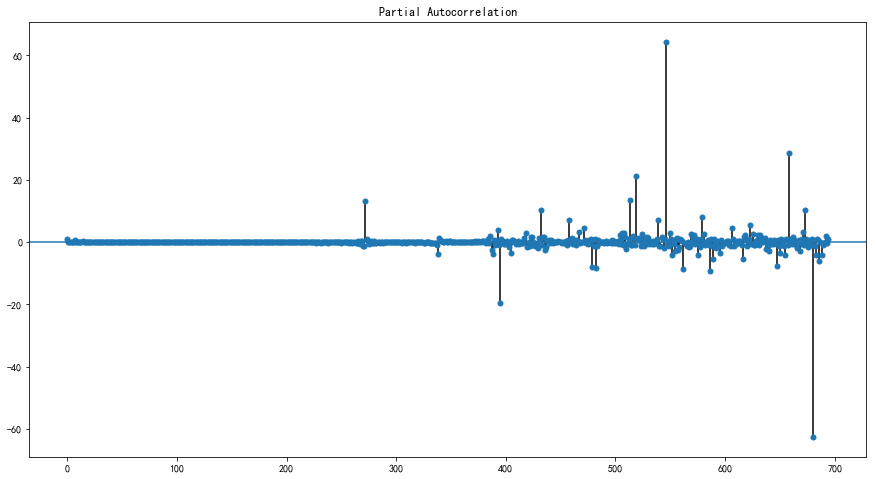

In [9]:
# 天的自相关图
plot_acf(df_day.order_num.values).show()
plot_pacf(df_day.order_num.values).show()

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


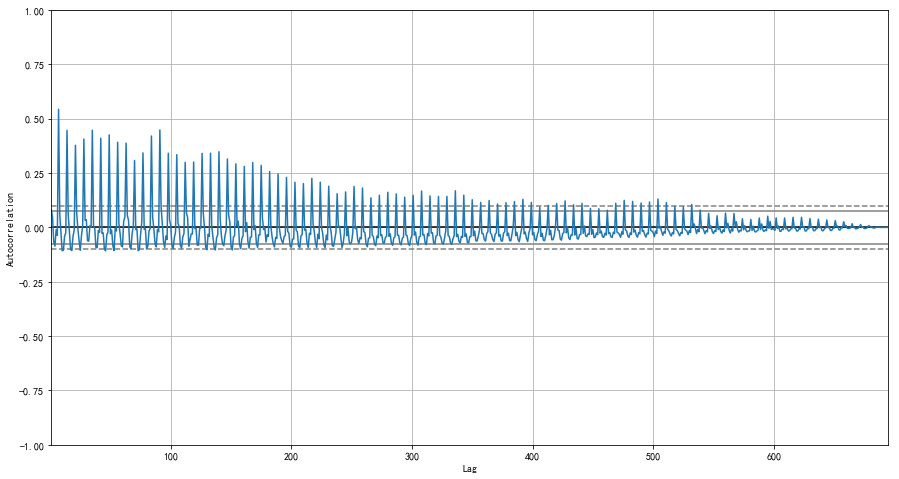

In [10]:
autocorrelation_plot(df_day.order_num.values)
plt.show()

### 2.2 单位根检验

In [11]:
# 月的单位根检验
adf_result = adfuller(df_day.order_num.values)
output = pd.DataFrame(index=["Test Statistic Value", "p-value", "Lags Used", "Number of Observations Used", "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"], columns=['value'])
output['value']['Test Statistic Value'] = adf_result[0]
output['value']['p-value'] = adf_result[1]
output['value']['Lags Used'] = adf_result[2]
output['value']['Number of Observations Used'] = adf_result[3]
output['value']['Critical Value (1%)'] = adf_result[4]['1%']
output['value']['Critical Value (5%)'] = adf_result[4]['5%']
output['value']['Critical Value (10%)'] = adf_result[4]['10%']
print("月的单位根检验结果为：")
print(output)

月的单位根检验结果为：
                                   value
Test Statistic Value            -4.61682
p-value                      0.000120256
Lags Used                             13
Number of Observations Used          681
Critical Value (1%)             -3.43999
Critical Value (5%)             -2.86579
Critical Value (10%)            -2.56904


### 2.3 纯随机性检验

In [12]:
# 月的纯随机性检验
print("序列的纯随机性检验结果为：")
print(acorr_ljungbox(df_day.order_num.values, lags=1)[1][0])

序列的纯随机性检验结果为：
0.03297564006719209


## 3 模型拟合

### 3.1 Holt-Winters method

In [13]:
train, test = train_day.order_num.values, test_day.order_num.values

In [14]:
model = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add')
model_fit = model.fit()
preds = model_fit.forecast(90)

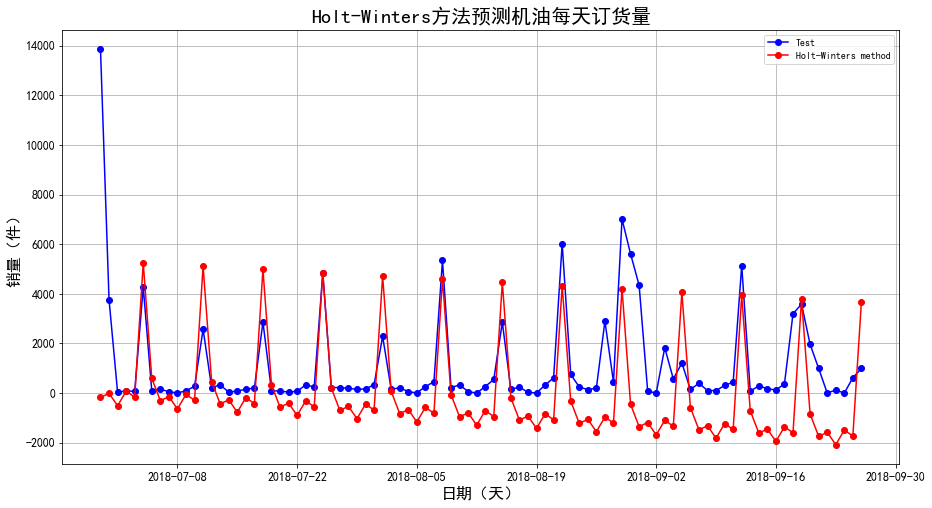

In [15]:
fig, ax = plt.subplots()
# ax.plot(train_day.index, train_day.order_num.values, 'go-', label='Train')
ax.plot(test_day.index,test, 'bo-', label='Test')
ax.plot(test_day.index, preds, 'ro-', label='Holt-Winters method')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('Holt-Winters方法预测机油每天订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [16]:
rmse = sqrt(mean_squared_error(test, preds))
print("The RMSE of 'Holt-Winters method' is:", rmse)

The RMSE of 'Holt-Winters method' is: 2324.658129471686


### 3.2 ARIMA

In [17]:
train, test = train_day.order_num.values, test_day.order_num.values

In [18]:
arma_order_select_ic(train, max_ar=6, max_ma=4, ic='aic')['aic_min_order']

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


(4, 4)

In [19]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = ARMA(history, order=(4, 4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat[0])
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

expected = 13852.000000 predicted = 1339.474826
expected = 3760.000000 predicted = -143.935189
expected = 24.000000 predicted = -619.720013
expected = 96.000000 predicted = 1584.881828
expected = 64.000000 predicted = -746.848953
expected = 4276.000000 predicted = 3359.522218
expected = 84.000000 predicted = 401.521301
expected = 156.000000 predicted = 2197.121348
expected = 56.000000 predicted = 33.898206
expected = 0.000000 predicted = -698.286857
expected = 92.000000 predicted = 1497.275574
expected = 272.000000 predicted = -462.593164
expected = 2572.000000 predicted = 3488.514206
expected = 220.000000 predicted = 333.102349
expected = 332.000000 predicted = 2110.457570
expected = 36.000000 predicted = -70.107122
expected = 84.000000 predicted = -533.849598
expected = 152.000000 predicted = 1391.410929
expected = 204.000000 predicted = -251.954025
expected = 2860.000000 predicted = 3400.154384
expected = 96.000000 predicted = 353.484006
expected = 76.000000 predicted = 2038.224425


In [40]:
temp = np.array(preds).reshape((len(test), -1))
print("误差比例为：%.2f%%" % (error_prop(test, temp) * 100.0))

误差比例为：98.76%


In [42]:
print("实际值：%f 预测值：%f" % (test[0], temp[0]))

实际值：13852.000000 预测值：1339.474826


In [41]:
error_prop(test[0], temp[0])

0.90330097991806

In [50]:
error_prop(test[2:], temp[2:])

0.8544598813726293

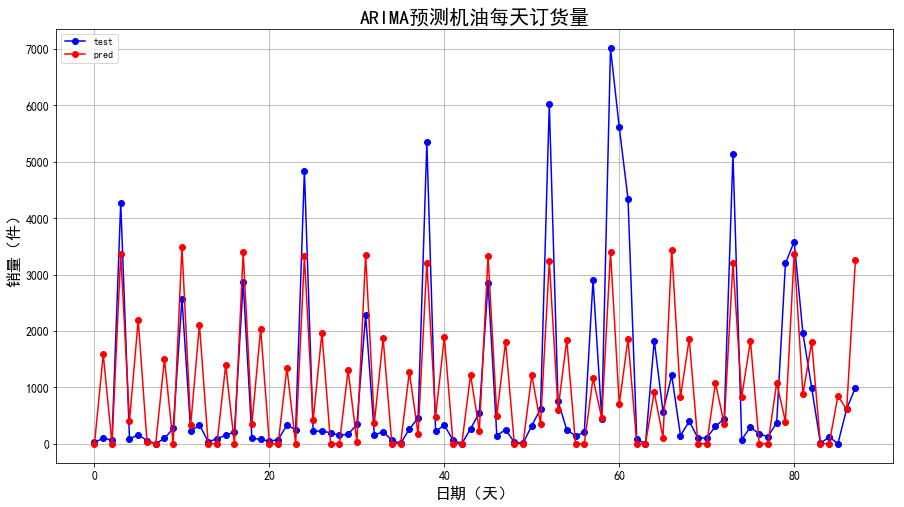

In [51]:
# temp
fig, ax = plt.subplots()
ax.plot(test[2:], 'bo-', label='test')
ax.plot(temp[2:], 'ro-', label='pred')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('ARIMA预测机油每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()

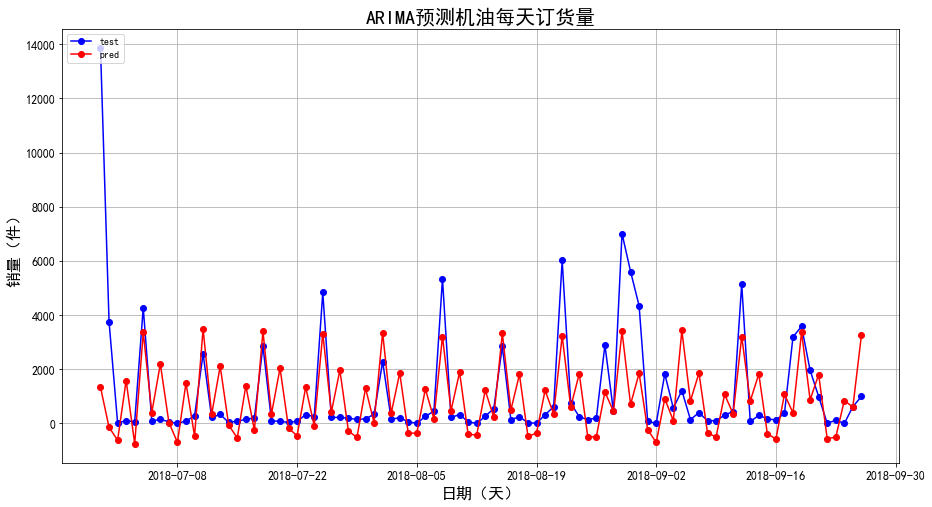

In [21]:
fig, ax = plt.subplots()
ax.plot(test_day.index, test, 'bo-', label='test')
ax.plot(test_day.index, preds, 'ro-', label='pred')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('ARIMA预测机油每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()

### 3.3 SARIMAX

In [29]:
train, test = train_day.order_num.values, test_day.order_num.values

NameError: name 'train_month' is not defined

In [30]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = SARIMAX(train, order=(5, 0, 4), seasonal_order=(0, 1, 1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 444.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 7012.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5608.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 4344.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 80.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 0.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1828.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 568.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1212.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 144.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 396.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 100.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 100.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 308.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 440.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5136.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 72.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 296.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 172.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 124.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 372.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 3196.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 3584.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1960.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 992.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 4.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 120.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 0.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 616.000000 predicted = 875.123609
expected = 996.000000 predicted = 875.123609
Test RMSE: 1947.732


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


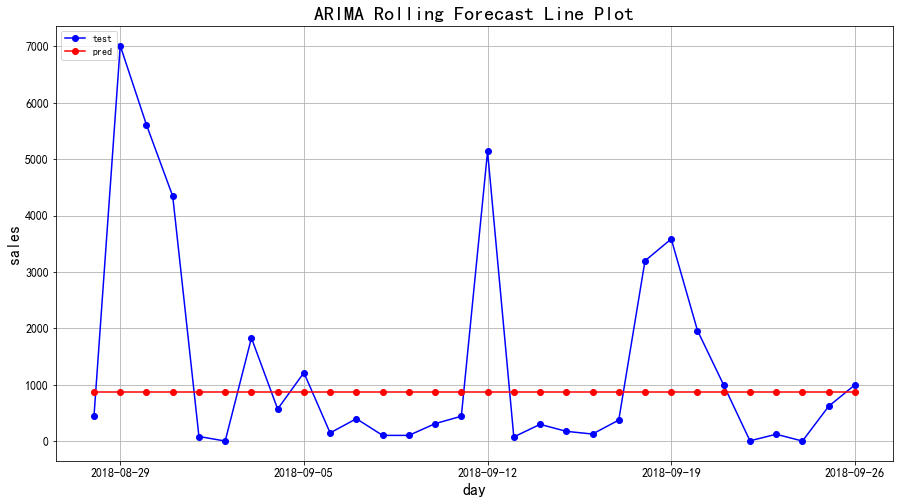

In [31]:
fig, ax = plt.subplots()
ax.plot(test_day.index, test, 'bo-', label='test')
ax.plot(test_day.index, preds, 'ro-', label='pred')
ax.set_xlabel('day', fontsize=16)
ax.set_ylabel('sales', fontsize=16)
ax.set_title('ARIMA Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()